In [1]:
#!pip install tensorflow
#!pip install keras
#!pip install theano

# Análisis salida de clientes para entidad bancaria

## Resumen
Una entidad bancaria ha detectado que un indeterminado número de clientes se ha retirado de su banco de manera anomala. Se nos pide desarrollar un sistema que determine cual es la posibilidad que un cliente se retire de la entidad bancaria a partir de los datos del usuario. Este banco opera en diferentes naciones europeas. 
Para ello nos han entregado una base de datos de 10.000 clientes. Con los siguientes datos:

- Customer: ID del cliente
- Surname: Apellido
- Credit score: record crediticio
- Geography: País
- Gender: Genero
- Age: Edad
- Tenure: Estado del cliente
- Balance: Balance
- NumOfProducts: Número de productos
- HasCrCard: Tiene 1 o no 0 tarjetas de credito 
- IsActiveMember: Es miembro activo
- StimateSalary: Salario estimado
- Exited: Permanece o se ha retirado del banco. 

Como se observa se trata de un problema de clasificación. El problema es de muchos a uno y la variable objetivo es Exited. 

**Nota 1:** Para el banco es mas diciente que entreguemos las probabilidad que un cliente se quede o se marche del banco.  
**Nota 2:** Este código requiere Python 3, TensorFlow, Theano

## Pasos para resolver el problema:

A continuación se resume la manera en que se abordara el problema. Usaremos una red neuronal artificial RNA como metódo de solución.

1. Cargar las librerias de análisis de datos
2. Cargar y tratamiento de los datos suministrados por el banco

## 0. Cargar las librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga de datos y tratamiento
Los datos se deben cargar usando una ruta al directorio en caso que los datos se encuentren en carpetas independientes

In [3]:
data = pd.read_csv("Churn_Modelling.csv")
print(data.shape)
data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Variables independientes y dependientes
Solo vamos a usar los valores del conjunto de datos y no tendremos en cuenta el indice ni los encabezados. 

X = Variables independientes eliminamos las columanas de rowNumber, CustomerId y Surname debido a que no aportan información del comportamiento de un cliente al modelo y por supuesto la variable de salida exited. 

y = Variable de salida en este caso Exited

In [4]:
X = data.iloc[:,3:13].values
y = data.iloc[:,13].values
print(f'X = {X.shape} y= {y.shape}')

X = (10000, 10) y= (10000,)


### Decodificación de datos
Esta base de datos cuenta con datos categoricos. Las RNA al igual que otros modelos de análisis requieren de datos númericos para trabajar. Es necesario decodificar estos datos para tener información interpretable por el modelo que se diseñara.
Esta es la lista de datos categoricos:
- Geography: País
- Gender: Genero 
Tenemos otros datos categoricos, pero estos se encuentran decodificados con un valor binario 0 y 1. Esto es suficiente para que el modelo interprete la información. Por lo tanto no es necesario hacer una decodificación de estos valores. 
- Tenure: Estado del cliente
- HasCrCard: Tiene 1 o no 0 tarjetas de credito 
- IsActiveMember: Es miembro activo
- Exited: Permanece o se ha retirado del banco. 

**Onehotencoder** Es una tecnica de códificación que me crea una variable dummy. Estas variables consisten en crear una nueva columna para cada categoria a partir de la columna inicial. Por ejemplo de la columan Geography obtendremos tres nuevas colunmas: francia, España, Alemania. Cada fila solo podra tener un 1 en una de las tres filas, por ejemplo un usuario Español tendria 010. Haciendo referencia a que solo pertenece a la categoria España. 

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Hacemos una variable dummy para la columna 1 de paises
ct = ColumnTransformer([("Geography", OneHotEncoder(), [1])], remainder = 'passthrough')
X = ct.fit_transform(X)

**Nota:** En el paso anterior se han creado tres columnas nuevas, por lo tanto la columna de genero pasa de ser la 2 a la 4

In [6]:
# Y una variable binaria o de nivel para la columna 2 genero de los clientes
labelencoder_X = LabelEncoder()
X[:, 4] = labelencoder_X.fit_transform(X[:, 4])

Si lo notas no es necesario tener tres columnas para los paises, pues si sabemos que un usuario pertenece al grupo 1 o 2 automaticamente se sabe que no sera del grupo 3. Así mismo si pertenece al grupo 3 no pertenecera al 1 y 2. Hay que eliminar una columna y de esta manera evitamos el problema de multicolinealidad.

In [7]:
X = X[:,1:]
print(X.shape)

(10000, 11)


### División de los datos en train y test
Podemos hacer la división de manera manual, pero en este ejemplo usaremos la libreria de sklearn model_selection test_split- 

- Train: Datos que se usaran para determinar los mejores parametros de nuestra red en el entrenamiento
- Test: Datos que usaremos para evaluar el comportamiento del modelo frente a datos desconocidos 

La división de los datos se hara en una proporcion del 20% o 0.2 y con una semilla a 0 para hacer el modelo replicable

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f'X_train {X_train.shape}, X_test{X_test.shape}, y_train{y_train.shape}, y_test{y_test.shape}')

X_train (8000, 11), X_test(2000, 11), y_train(8000,), y_test(2000,)


### Normalizacioón de los datos.

La normalización de los datos es un proceso basico para cualquier red neuronal. De esta manera evitamos que un modelo de mayor relevancia a un dato que a otro, solo por tener un valor neto más grande. 

In [9]:
from sklearn.preprocessing import StandardScaler
#Creamos un objeto base para escalar las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#Usamos la misma base de escala para los datos de test pues pertenecen al mismo grupo
X_test = scaler.fit_transform(X_test)

**NOta 1:** Para la variable independiente no es necesario hacer este escalado, pues los datos son categoricos y este proceso no tiene sentido.
**Nota 2:** Para algunos cientificos no es necesario escalar las variables categoricas pues se pierde el proceso de categorización. Para otros es necesario para mantener la escala entre los datos y mejorar el rendimiento al buscar los hiperparametros en el proceso de entrenamiento. Esto se deja a criterio del analista de los datos. 

## 2. Construir la red neuronal
Las capas densas son capas con neuronas que se conectan todas con las neuronas de las capas layers contiguas.

In [10]:
from keras.layers import Dense
from keras.models import Sequential

In [11]:
#Crear un objeto contenedor de capas secuenciales
model = Sequential()

La primera capa requiere que se le agrege en la primera capa la informacion del numero de entradas, el cual es igual al número de variables independientes en este caso 11 y el número de neuronas en la primera capa oculta. De igual manera al declarar la capa Dense esta inicializa los pesos de la red con valores cercanos a cero de manera automatica. 
- units = neuronas de la capa oculta. En este caso usaremos la formula (#de entradas + #de salidas)/2 = (11+1)/2=6
- kernel_initializer: Función para inicializar los pesos iniciales de la red neuronal. Glorot esta por defecto
- activation = relu. Esta función indica cuando una neurona de una capa se activara. Este valor es común para todas las neuronas de una misma capa. 
- input_dim: 11 Es el número de variables de entrada. Remplaza input_shape = [11,6] el cual es un tensor y requiere se especifique el número de variables de entrada y el número de neuronas en la capa oculta. 

In [12]:
#Agregar primer capa densa
#model.add(Dense(units=6, kernel_initializer = 'uniform', activation='relu',input_shape=[11,6]))
model.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu", input_dim = 11))

**Nota:** Indicar el número de variables de entrada solo es necesario en la primer capa de la RNE.

In [13]:
#Agregar la segunda capa oculta
model.add(Dense(units=6, kernel_initializer = 'uniform', activation='relu'))

La capa de salida debe tener solo el mismo número de neuronas que las variables de salida, en este caso 1 salida. Como el cliente desea saber cual es el porcentaje de probabilidad que un cliente se quede o se retire del banco, usaremos una activación que me entregue una probabilidad. Por tal motivo usaremos una activación *sigmoide*. 

**Nota:** Esto solo sirve para una clasificación binaria. Para usar tres o mas categorias requiere usar un escalon, una relu o si deseas usar la sigmoide requiere una capa adicional con una activación softmax para que los porcentajes probables de salida sumen uno

In [14]:
#Agregar la capa de salida
model.add(Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid'))

In [15]:
#Mostrar un resumen del modelo 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


## 3. Entrenar la red neuronal
En esta etapa se **compila** el modelo. Al compilar el modelo, se inicializan los pesos con un kernel uniforme, se ejecuta la propagación hacia adelante y hacia atras. Los parametros del compilador son:
- optimaizer: Optimizador que usaremos para llegar al optimo, por defecto tenemos el ADAM. Es el mas recomendable
- loss: Función de perdida entre los datos calculados y el real. Usarmos las suma de cuadrados ordinarios. Usaremos binary_crossentropy, la cual hace la diferencia entre y con y_hat, le aplica un logaritmo y transforma las categorias a numeros. 
- metrics: A este parametro podemos solicitar que nos entregue tantas metricas de medida como queramos, debemos enviar los datos en un arreglo con las metricas a usar. El algoritmo intentara mejorar la metrica que enviemos en cada una de sus iteraciones. En este caso solo usaremos las presición accuracy. 

In [16]:
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

### Entrenamiento o ajuste .fit
Los argumentos están divididos como:
- x= debe ser un arreglo con los datos correspondientes a los datos de entrenamiento para las variables independientes  X_train
- y= debe ser un arreglo con los datos correspondientes a los datos de entrenamiento para la variable dependiente y_train
- epochs = es la cantida de veces que deseamos que la red se re entrene. Si aplicamos demasiadas epocas tendremos un problema de overfit. 
- batch_size = al entrenar no pasamos todo el conjunto de datos en una sola epoca, para mejorar la eficiencia de computo enviamos los datos en tramos o divisiones. En este argumento indicamos la cantidad de datos en cada tramo. 
- validation_split = es recomendable usar un conjunto de validación que es tomado de los datos de train, este conjunto ayuda a mejorar el ajuste de los hiperparametros de la red en cada epoca. En este argumento podemos indicar el porcentaje de datos que usaremos en cada epoca como validation. Acepta valores entre 0 y 1. Se sugiere usar un 20% de los datos para validación.
- validation_data = En caso de nosotros mismos tomar una cantida de datos previamente desde los valores de test, debemos entregarlos en forma de tensor en este argumento [X_val, y_val].
- steps_per_epoch = Entero. Número total de pasos (lotes de muestras) a ceder del generador antes de declarar una época terminada y comenzar la siguiente época. Por lo general, debe ser igual a num_samples ó batch_size. Es opcional. Su función es mejorar el proceso de entrenamiento cuando la red no logra disminuir su porcentaje de perdida. 
- verbose = 1 para ver en pantalle el proceso de entrenamiento y 0 para ocultarlo. Por defecto esta en 1.

**Nota:** Los datos de validación son opcionales para el comando fit. Para algunos analistas este conjunto es mas importante que el conjunto de test. Cuando la cantidad de datos son pocos, se sugiere usar solo los datos de validation y train.

https://gombru.github.io/2018/05/23/cross_entropy_loss/

In [17]:
model.fit(X_train, y_train,  batch_size = 10, epochs = 100)

Epoch 1/100
800/800 [==============================] - 0s 537us/step - loss: 0.5078 - accuracy: 0.7952
Epoch 2/100
800/800 [==============================] - 0s 464us/step - loss: 0.4228 - accuracy: 0.7960
Epoch 3/100
800/800 [==============================] - 0s 459us/step - loss: 0.4146 - accuracy: 0.7960
Epoch 4/100
800/800 [==============================] - 0s 455us/step - loss: 0.4068 - accuracy: 0.8001
Epoch 5/100
800/800 [==============================] - 0s 456us/step - loss: 0.3993 - accuracy: 0.8264
Epoch 6/100
800/800 [==============================] - 0s 458us/step - loss: 0.3926 - accuracy: 0.8288
Epoch 7/100
800/800 [==============================] - 0s 448us/step - loss: 0.3867 - accuracy: 0.8294
Epoch 8/100
800/800 [==============================] - 0s 454us/step - loss: 0.3811 - accuracy: 0.8394
Epoch 9/100
800/800 [==============================] - 0s 475us/step - loss: 0.3777 - accuracy: 0.8390
Epoch 10/100
800/800 [==============================] - 0s 462us/step - l

800/800 [==============================] - 0s 443us/step - loss: 0.3435 - accuracy: 0.8610
Epoch 80/100
800/800 [==============================] - 0s 457us/step - loss: 0.3443 - accuracy: 0.8619
Epoch 81/100
800/800 [==============================] - 0s 454us/step - loss: 0.3439 - accuracy: 0.8612
Epoch 82/100
800/800 [==============================] - 0s 446us/step - loss: 0.3440 - accuracy: 0.8569
Epoch 83/100
800/800 [==============================] - 0s 448us/step - loss: 0.3442 - accuracy: 0.8600
Epoch 84/100
800/800 [==============================] - 0s 446us/step - loss: 0.3435 - accuracy: 0.8630
Epoch 85/100
800/800 [==============================] - 0s 446us/step - loss: 0.3438 - accuracy: 0.8601
Epoch 86/100
800/800 [==============================] - 0s 439us/step - loss: 0.3438 - accuracy: 0.8601
Epoch 87/100
800/800 [==============================] - 0s 439us/step - loss: 0.3442 - accuracy: 0.8606
Epoch 88/100
800/800 [==============================] - 0s 445us/step - loss:

## Evaluar el modelo y predecir datos.
Es momento de verificar el comportamiento de la red neuronal con datos desconocidos. Es recomendable guardar los resultados Y_hat para hacer análisis de los resultados. En este caso los valores que tenemos son probabilidades. Un metodo para definir que clientes abandonaran los datos podemos usar un porcentaje umbral. Entre mas alto es el porcentaje medido, sera mas probable que el cliente abandone el banco. Generalmente es necesario acordar este umbral con el banco. 

In [18]:
y_hat = model.predict(X_test)

In [19]:
y_hat.shape

(2000, 1)

#### Matriz de confusión
Es un metodo para evaluar el comportamiento del modelo propuesto. Es necesario trabajar con valores categoricos, por lo tanto aplicaremos un umbral del 50% para definir los clientes que abandonan o no el banco. Y así medir la tasa de falsos positivos, falsos negativos y aciertos que ha logrado obtener nuestro modelo. 

In [20]:
#Convertir a categorias nuestros resultados 1 abandona, 0 se mantiene el cliente en el banco
y_hat = (y_hat>0.5)
print(y_hat[1:5,:])

[[False]
 [False]
 [False]
 [False]]


In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_hat)
print((cm[0][0]+cm[1][1])/cm.sum())

0.8605


#### Grafica matriz de confusión
La matriz de confusión se puede representar de manera grafica. En su diagonla principal se presentan los valores correctamente predichos. Se ordena como:

|                      |                      |
| :------------------: | :------------------: |
| Verdaderos-positivos | Falsos-negativos     |
| Falsos-negativos     | Verdaderos-negativos |


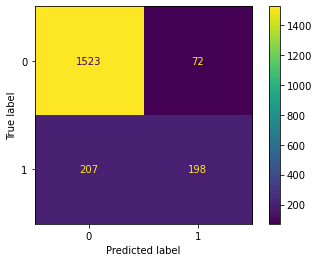

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm).plot()